<h1>Cuberg DS Challenge: Electrolyte Design using ML</h1>

Written by Daniel Cohen: daniel.parke.cohen@gmail.com for Cuberg Data Scientist position

In [1]:
import os,sys

# Common imports
import numpy as np
import os
import joblib
import urllib

# Data Science/ML imports
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras

# plotting imports
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Get started by reading data from .csv files as pandas DataFrames

In [2]:
form=pd.read_csv("formulations.csv",index_col=0)
meas=pd.read_csv("measurements.csv",index_col=0)
data=pd.concat([form,meas],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, F-0 to F-91
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Salt-A         92 non-null     float64
 1   Salt-B         92 non-null     float64
 2   Salt-C         92 non-null     float64
 3   Solvent-A      92 non-null     float64
 4   Solvent-B      92 non-null     float64
 5   Solvent-C      92 non-null     float64
 6   Additive-A     92 non-null     float64
 7   Additive-B     92 non-null     float64
 8   Measurement-1  92 non-null     float64
 9   Measurement-2  92 non-null     float64
 10  Measurement-3  92 non-null     float64
dtypes: float64(11)
memory usage: 8.6+ KB


array([[<AxesSubplot:title={'center':'Salt-A'}>,
        <AxesSubplot:title={'center':'Salt-B'}>,
        <AxesSubplot:title={'center':'Salt-C'}>],
       [<AxesSubplot:title={'center':'Solvent-A'}>,
        <AxesSubplot:title={'center':'Solvent-B'}>,
        <AxesSubplot:title={'center':'Solvent-C'}>],
       [<AxesSubplot:title={'center':'Additive-A'}>,
        <AxesSubplot:title={'center':'Additive-B'}>,
        <AxesSubplot:title={'center':'Measurement-1'}>],
       [<AxesSubplot:title={'center':'Measurement-2'}>,
        <AxesSubplot:title={'center':'Measurement-3'}>, <AxesSubplot:>]],
      dtype=object)

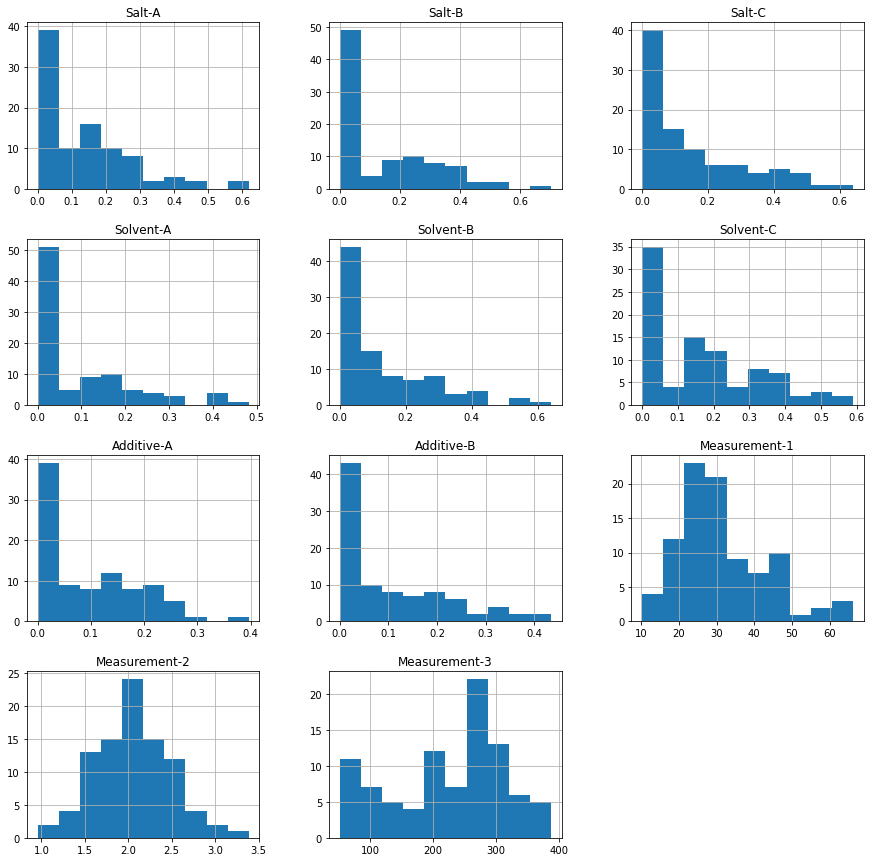

In [3]:
data.hist(figsize=(15,15))

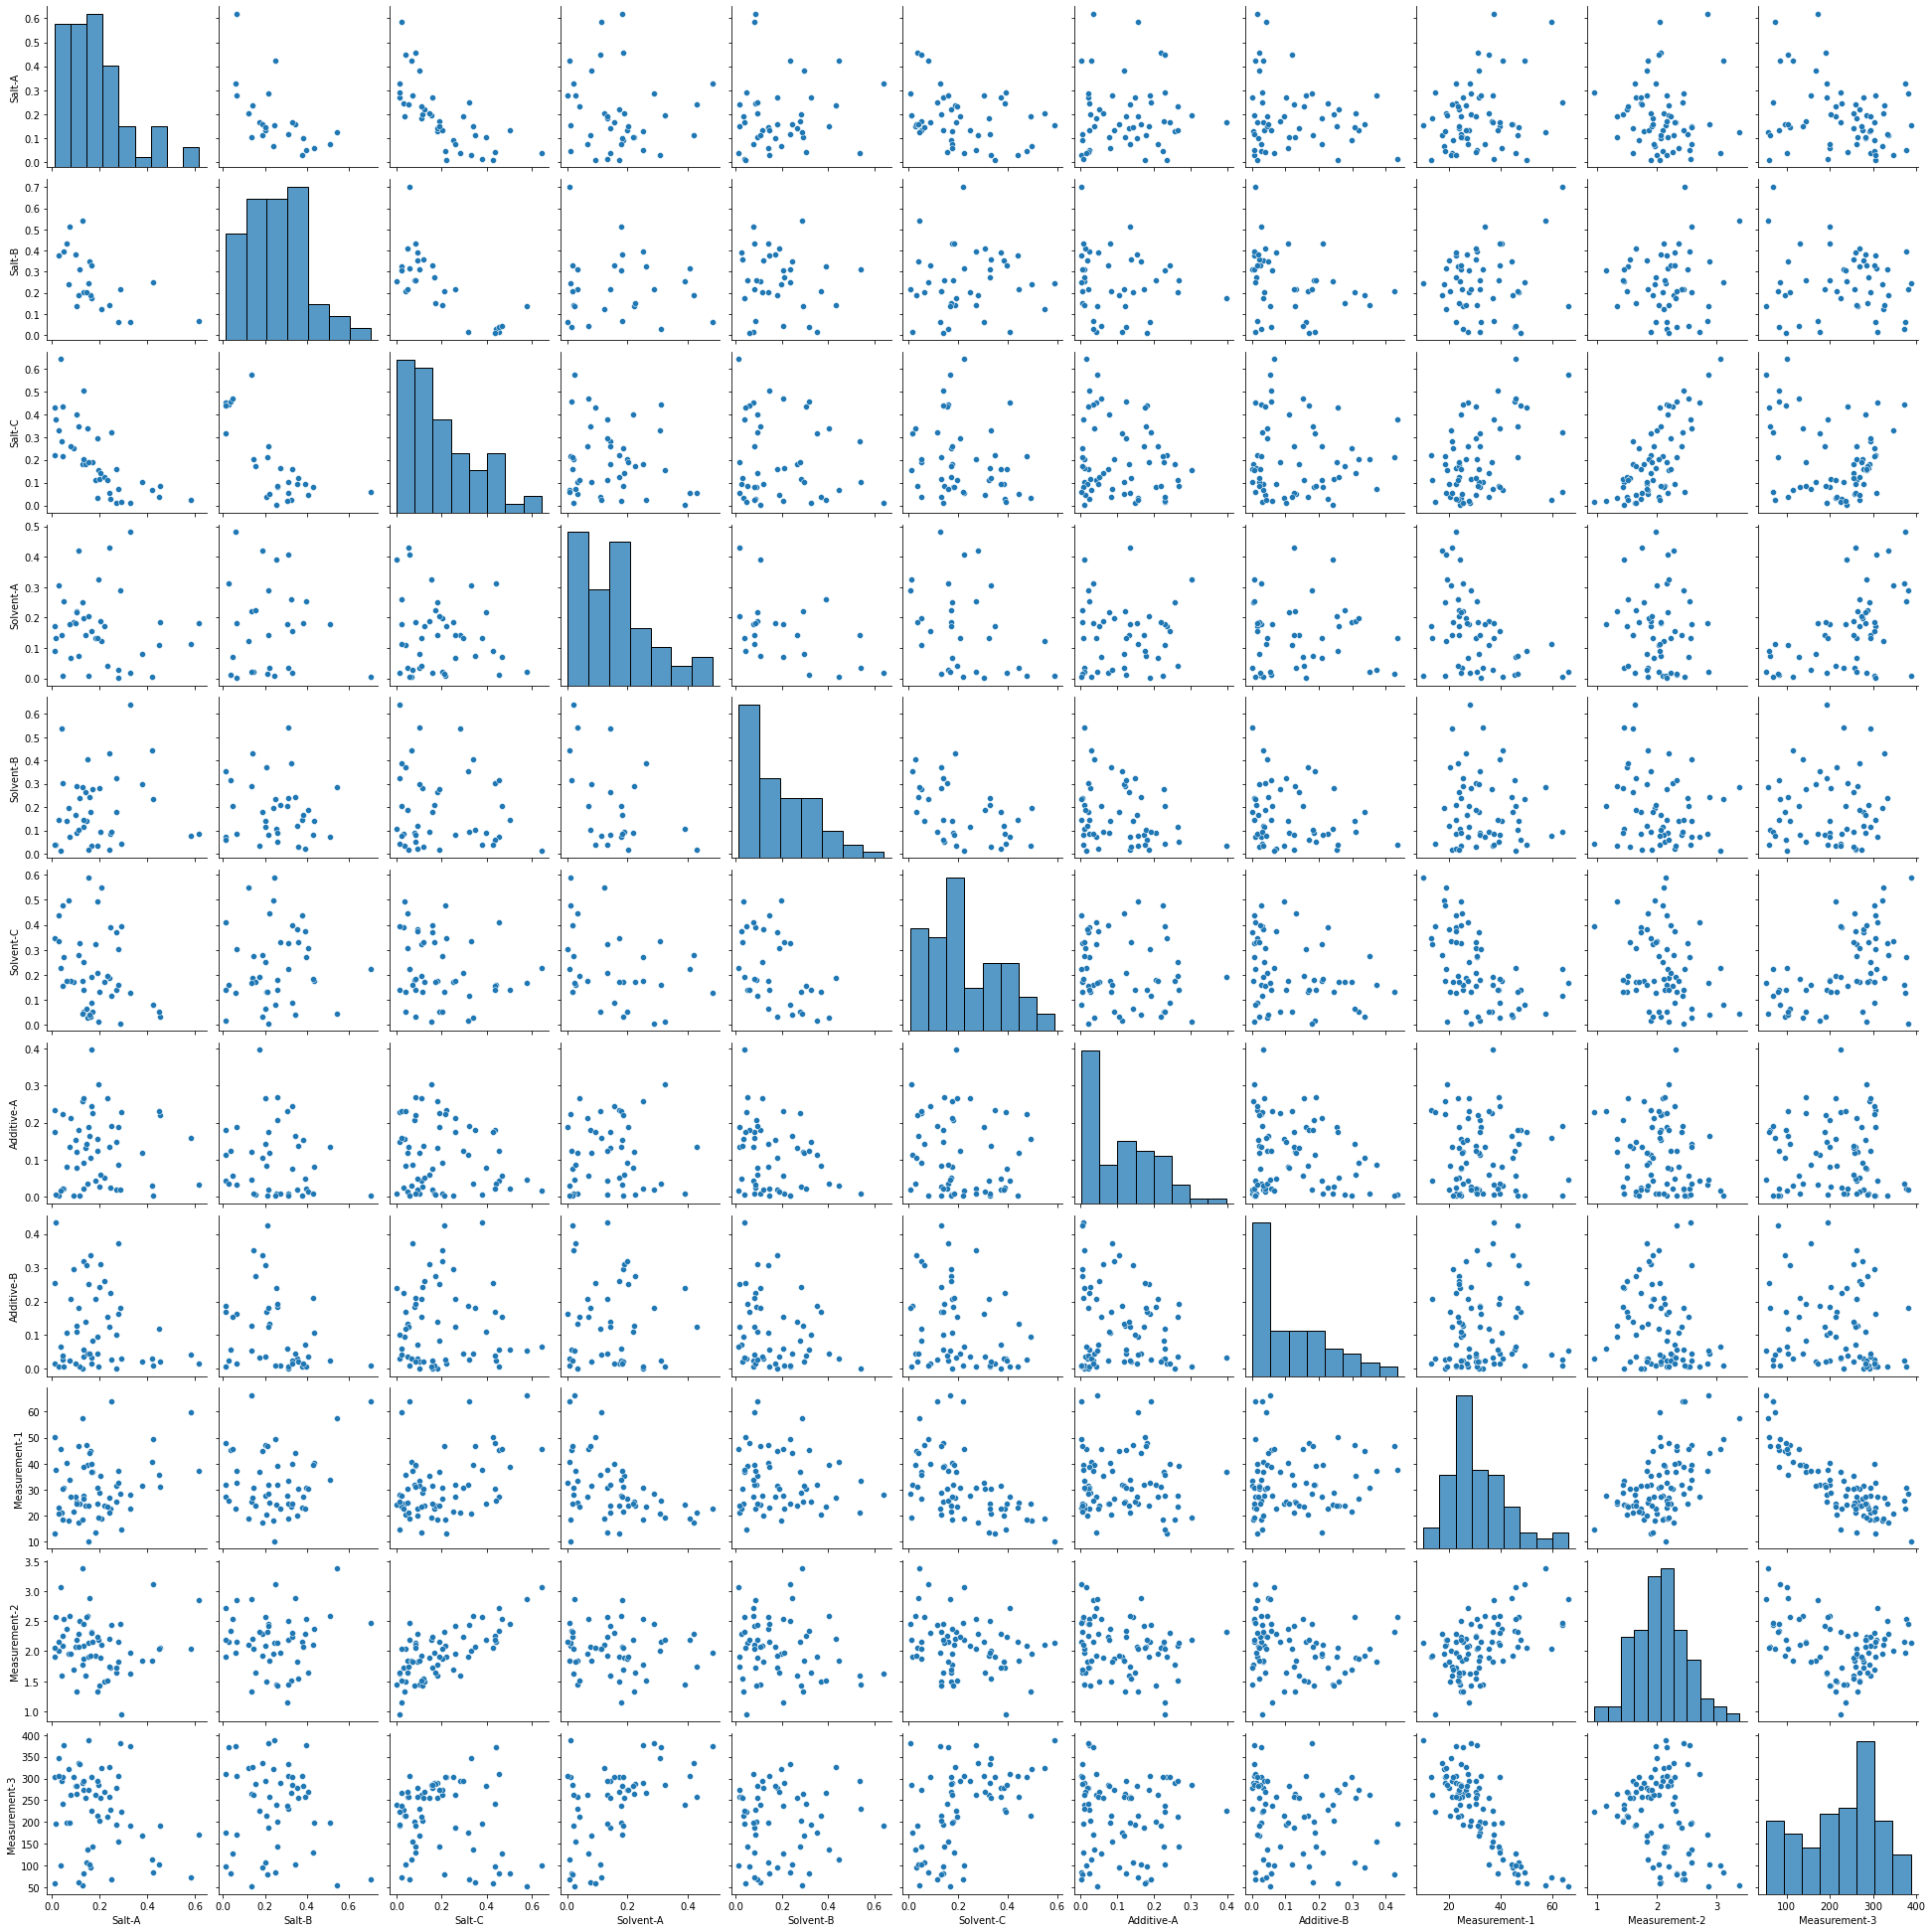

In [4]:
data_masked=data.mask(data==0.)
sns.pairplot(data_masked)#,dropna=True)


/Users/dcohen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dcohen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dcohen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<function matplotlib.pyplot.show(close=None, block=None)>

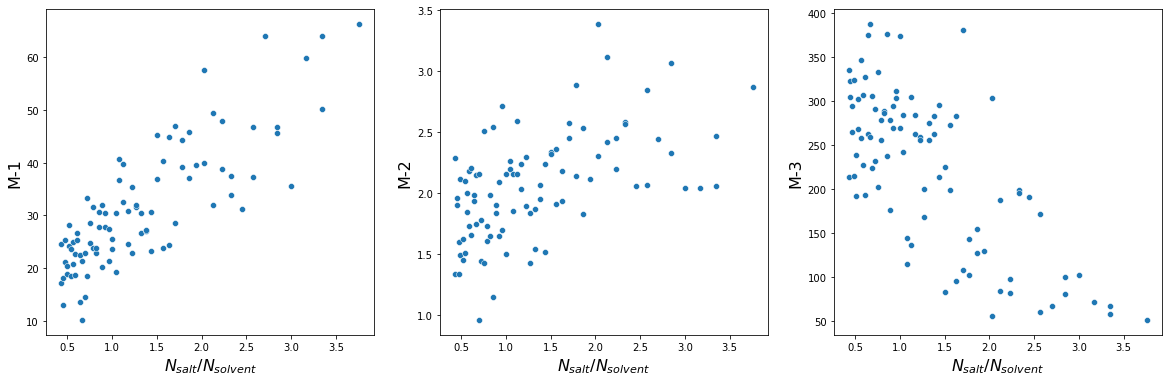

In [5]:
# Form total salts/total solvent ratio.
salt_to_solvent=data_masked.loc[:,'Salt-A':'Salt-C'].sum(axis=1)/data_masked.loc[:,'Solvent-A':'Solvent-C'].sum(axis=1)#,\
salt_to_add=data_masked.loc[:,'Salt-A':'Salt-C'].sum(axis=1)/data_masked.loc[:,'Additive-A':'Additive-B'].sum(axis=1)
salt_to_rest=data_masked.loc[:,'Salt-A':'Salt-C'].sum(axis=1)/data_masked.loc[:,'Solvent-A':'Additive-B'].sum(axis=1)#,\


plt.figure(figsize=(20,6))
# sns.scatterplot(salt_to_solvent.values,data.loc[:,'Measurement-1'].values)
# sns.scatterplot(salt_to_solvent.values,data.loc[:,'Measurement-2'].values)
# ax=plt.subplot(311)
for i in range(3):
    ax=plt.subplot(1,3,i+1)
    sns.scatterplot(salt_to_solvent,\
                data.loc[:,'Measurement-%i'%(i+1)].values,ax=ax)
#     plt.legend(['$M_1$','$M_2$','$M_1$'])
    ax.set_xlabel("$N_{salt}/N_{solvent}$",fontsize=16)
    ax.set_ylabel("M-%i"%(i+1),fontsize=16)
#     ax.annotate("Measurement-%i"%(i+1),xy=(0.1,0.9),xycoords='axes fraction')
#     ax.set_xscale('log')
plt.show


#### Preliminary insights: ####
- Formulations often exclude components, creating a large spike of 0s on histograms 
- Lots of scatter apparent with no correlation clear for additives
- Salt-A and C and Solvent-A and C show most correlations with Measurement-3
- Ratio of Salt/Solvent is a clearly important quantity in determining the physical properties. In particular:
- $N_{salt}/N_{solv}$ shows very tight correlation with physical properties,so is a good predictor for cycle life
    
Ready to proceed pre-processing data, then training models, predicting properties to find formulations which yield high cycle life (Meaurement-3>400).

<h2> Split the reduced and full data into a training set and a testing set </h2>

In [6]:
from sklearn.model_selection import train_test_split 

X,y=data.loc[:,'Salt-A':'Additive-B'],data.loc[:,'Measurement-1':'Measurement-3']


X_train , X_test, y_train, y_test = train_test_split (X, \
                                                      y,\
                                                      test_size = 0.1 , random_state = 0,\
                                                      shuffle=True )


In [7]:
# pd.concat([X_train,y_train],axis=1).to_csv("train.csv")
# pd.concat([X_valid,y_valid],axis=1).to_csv("valid.csv")
# pd.concat([X_test,y_test],axis=1).to_csv("test.csv")

### Scale data and define functions for pipeline, including for linearregression, lasso/ridge, and 

In [8]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train) 
X_test=scaler.transform(X_test)#,X_test=std_scale(X_train,X_test)


In [63]:
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error



def lin_model():
    return LinearRegression(fit_intercept=True)

def elasticnet_model():
    return ElasticNet(random_state=42 , alpha=0.1, l1_ratio=0.5, max_iter=2000)

def seq_fit(X_train,y_train,X_test,y_test):
    n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]  
    model = keras.Sequential()
    model.add(keras.layers.Dense(5, input_dim=n_inputs, activation='relu'))
    model.add(keras.layers.Dense(n_outputs))
    model.compile(loss = "mse" , \
               optimizer = "sgd" )
#     model.compile(loss='mae', optimizer='adam')
    history=model.fit(X_train, y_train, verbose=0, epochs=30)
    y_predict=model.predict(X_test)
    msq = mean_squared_error(y_test,y_predict)
    mae=mean_absolute_error(y_test,y_predict)
    r2=r2_score(y_test,y_predict)
    scores=(msq,mae,r2)
    
    print("MSE: %f, MAE: %f, R^2: %f"%(msq,mae,r2))
    return model,scores
# def make_pipe(model):
#     scaler=StandardScaler()
#     return make_pipeline(scaler,model)

# evaluate a model using repeated k-fold cross-validation
def reg_fit(X_train,y_train,X_test,y_test,model=lin_model(),val=None):
    """
    Replace LinearRegressor with SeqModel(n_input,n_output) as needed
    """
    n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]  
    
    print(model)

    
    model.fit(X_train, y_train)
        
    # calculate predicted test y values
    y_predict=model.predict(X_test)
    
    # calculate metrics 
    msq = mean_squared_error(y_test,y_predict)
    mae=mean_absolute_error(y_test,y_predict)
    r2=r2_score(y_test,y_predict)
    scores=(msq,mae,r2)
    
    print("MSE: %f, MAE: %f, R^2: %f"%(msq,mae,r2))

    return model,scores



### Train LinearRegression and ElasticNet models then Sequential

In [65]:
lin_mod,lin_metrics=reg_fit(X_train,y_train,X_test,y_test,model=lin_model())


LinearRegression()
MSE: 674.069209, MAE: 13.140116, R^2: 0.597688


In [11]:
import pickle
fo=open('Linear_model.pkl', 'wb')
pickle.dump(lin_mod, fo)

In [64]:
elanet_mod,elanet_metrics=reg_fit(X_train,y_train,X_test,y_test,model=elasticnet_model())

# print("Linear Model metrics",lin_metrics)
# print("ElasticNet Model metrics",elanet_metrics)

ElasticNet(alpha=0.1, max_iter=2000, random_state=42)
MSE: 699.794829, MAE: 12.780066, R^2: 0.517724


In [13]:
fo=open('ElasticNet_model.pkl', 'wb')
pickle.dump(elanet_mod, fo)

ElasticNet is pretty solid. Now try Sequential (neural net).

In [66]:
seq_mod,seq_metrics=seq_fit(X_train,y_train,X_test,y_test)
                            

MSE: 3346.987081, MAE: 32.281113, R^2: -1.562418


In [15]:
# print("Sequential Model metrics",seq_metrics)
seq_mod.predict(X_test)
seq_mod.save('Sequential_model.h5')


## Predict new data
- Generate a new grid of X (components)
- Predict Measurements (1-3) with trained model
- Find X where Meas 3 >400

In [301]:
# Function to find new grid of X
# NEEDS IMPROVEMENT - DRAWING MORE EVENLY ACROSS 0-1
def make_sample(N_samp,N_c):
    
    N_r=N_samp//N_c
#     N_samp=N_r*N_c
    samp_c=np.random.rand(N_samp)
    samp_other=np.random.rand(N_samp,N_c-1)
    sum_true=np.ones(samp_c.size)-samp_c
    sum_now=samp_other.sum(axis=1)
    scale=sum_true/sum_now
    for i in range(samp_other.shape[1]):
        samp_other[:,i]=scale*samp_other[:,i] 
#     plt.hist(samp_c)
   
    X_samp=np.zeros([N_samp,N_c])
    # loop through each column, generate N_sample/N_col samples per column
    for c in range(N_c): 
#         print(samp_other[:, :c])
        X_samp[c*N_r:c*N_r + N_r , 0:c]= samp_other[c*N_r:c*N_r + N_r, 0:c] 
        X_samp[c*N_r:c*N_r + N_r, c] = samp_c[c*N_r:c*N_r + N_r] # lead column distributed more towards 1.0
        X_samp[c*N_r:c*N_r + N_r, c+1 :]= samp_other[c*N_r:c*N_r + N_r,c:]

    return X_samp

N_per_col=int(1e3)

X_new = make_sample(N_per_col*X.shape[1],X.shape[1])

X_new=pd.DataFrame(X_new,columns=X.columns)

#### Load trained models and predict measurements from new component formulations

In [181]:
import pickle

fo = open('Linear_model.pkl', 'rb')
lin = pickle.load(fo)
fo.close()
fo = open('ElasticNet_model.pkl', 'rb')
elnet = pickle.load(fo)
fo.close()

seq =keras.models.load_model('Sequential_model.h5')



In [302]:
# y_new_lin = lin.predict(scaler.transform(X_new))
# y_new_elnet = elnet.predict(scaler.transform(X_new))
y_new = pd.DataFrame(lin.predict(scaler.transform(X_new)),columns=data.columns[-3:])
data_new = pd.concat([X_new,y_new],axis=1).sort_values('Salt-A')



/Users/dcohen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dcohen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dcohen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


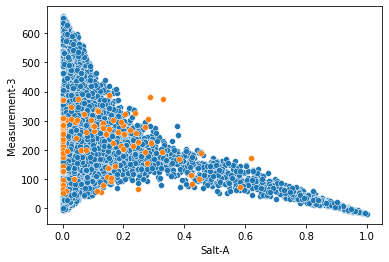

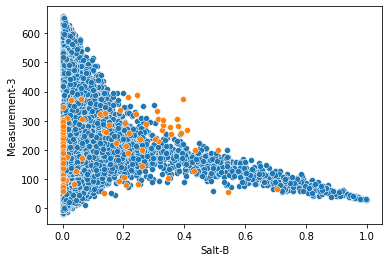

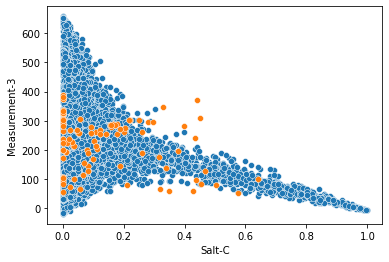

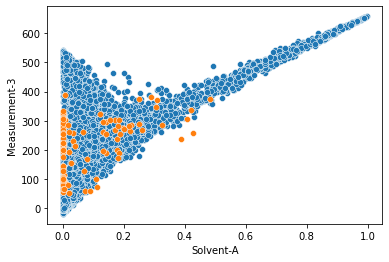

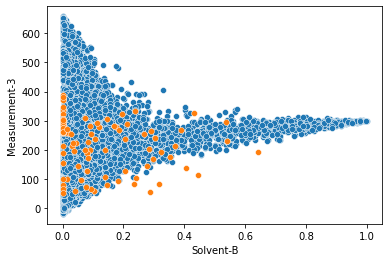

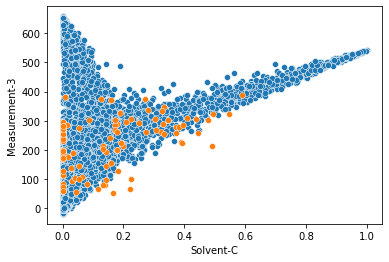

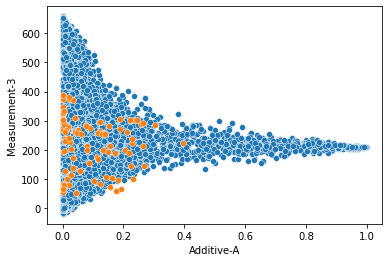

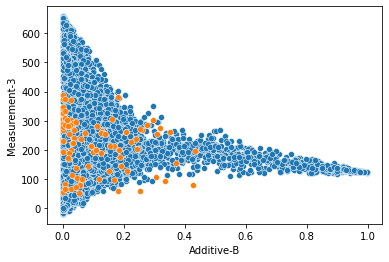

In [224]:
# data_new_lin = pd.DataFrame(np.concatenate([X_new,y_new_lin],axis=1),columns=data.columns)
# data_new_elnet = pd.DataFrame(np.concatenate([X_new,y_new_elnet],axis=1),columns=data.columns)
for c in X_new.columns:
    plt.figure()
    sns.scatterplot(data_new[c],data_new['Measurement-3'])
    sns.scatterplot(data[c],data['Measurement-3'])

### Cut data to $M_3>400$ and $M_{1,2}>0$ to find predicted formulations and save

In [389]:
ix_out=np.where( (data_new.loc[:,'Measurement-1']>=0.) & (data_new.loc[:,'Measurement-2']>=0.) \
                & (data_new.loc[:,'Measurement-3']>=390.) & (data_new.loc[:,'Measurement-3']<450.))
data_cut=data_new.iloc[ix_out].sort_values(by='Salt-A')

# data_new.iloc[ix_out].sort_values(by='Measurement-3')[2::2])/2.0
# data_cut
ix=np.arange(0,data_cut.shape[0],data_cut.shape[0]//10)

out=data_cut.iloc[ix.astype(int),:]
out.index=['F-%i'%i for i in range(92,92+out.shape[0])]
out.to_csv("formulations_new.csv")


# print(out)